In [161]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Variáveis de interesse

In [162]:
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))

In [163]:
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

In [164]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

/tmp/ipykernel_41234/4079747439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_41234/4079747439.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [165]:
# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100

In [166]:
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

In [167]:
def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)

In [168]:
def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)



In [169]:
def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)

In [170]:
def classify_idade(row):
    value = row['idade']
    if  20 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)

In [171]:
# LER ANTES!!!!!
# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']

In [172]:
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))

In [173]:
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

In [174]:
# Na literatura eles usam outra variável para analisar o consumo alcoolico
df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)

df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

In [175]:
# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'

df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

In [176]:
df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

In [177]:
df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

In [178]:
df = df[(df['idade'] >= 20) & (df['idade'] <= 59)] # Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'

# Análise de dados faltantes

## População total

In [179]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))


Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em PHQ9_total - classificação de grau de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0


In [180]:
print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))


Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em exerc_fisico - classificação de atividade física:  0 Perc: 0.0
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - classificação do consumo de álcool:  0 Perc: 0.0


In [181]:
print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))


Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  1295 Perc: 2.065
Faltantes em Q03001 - diagnostico diabetes:  5014 Perc: 7.996
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  5897 Perc: 9.404
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  0 Perc: 0.0
Faltantes em class_imc - classificação de imc:  340 Perc: 0.542


## População considerada depressiva (PHQ9>=10)

In [182]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))


Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0


In [183]:
print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))


Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em activity_class - classificação de atividade física:  4470 Perc: 67.218
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  0 Perc: 0.0


In [184]:
print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  58 Perc: 0.872
Faltantes em Q03001 - diagnostico diabetes:  316 Perc: 4.752
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  401 Perc: 6.03
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  0 Perc: 0.0
Faltantes em class_imc - classificação de imc:  56 Perc: 0.842


# Modelos

### Modelo apenas com habitos

In [185]:
df_habitos = pd.DataFrame()
df_habitos['upf'] = df['qst_upf']
df_habitos['exerc_fisico'] = df['exerc_fisico']
df_habitos['tabagismo'] = df['tabagismo']
df_habitos['cons_alcool'] = df['cons_alcool']
df_habitos['depression'] = df['depression']

In [186]:
df_habitos = df_habitos.dropna()

In [187]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [189]:
rf_classifier = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

In [190]:
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5360654866315846
Precision: 0.13141413031534996
Recall: 0.5923724616146607
F1-score: 0.21510791366906473


In [191]:
feature_importances = rf_classifier.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

upf: 0.3394817778332442
exerc_fisico: 0.289297962549245
tabagismo: 0.20506471103296314
cons_alcool: 0.16615554858454767


### Modelo apenas com as doenças crônicas

In [192]:
df_doencas = pd.DataFrame()
df_doencas['cancer'] = df['Q120']
df_doencas['hipertensão'] = df['Q00201']
df_doencas['diabetes'] = df['Q03001']
df_doencas['cardiovascular'] = df['Q06306']
df_doencas['hipercolesterolemia'] = df['Q060']
df_doencas['avc'] = df['Q068']
df_doencas['artrite'] = df['Q079']
df_doencas['obesidade'] = df['obesidade']
df_doencas['depression'] = df['depression']
df_doencas = df_doencas.replace(2.0, 0.0)

In [193]:
df_doencas = df_doencas.dropna()

In [194]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [196]:
rf_classifier = RandomForestClassifier(n_jobs=-1)

In [197]:
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6058115147824911
Precision: 0.6260905691732447
Recall: 0.5130038126361656
F1-score: 0.5639336900797065


In [198]:
feature_importances = rf_classifier.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

artrite: 0.26920329001267423
hipertensão: 0.17621309148638725
hipercolesterolemia: 0.15805605897633093
cardiovascular: 0.15410410522394405
avc: 0.07264864905732925
diabetes: 0.06959155113089258
cancer: 0.054589709737059726
obesidade: 0.04559354437538208


### Modelo com doenças e hábitos

In [199]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensão'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total = df_total.replace(2.0, 0.0)
df_total['upf'] = df['qst_upf']

In [200]:
df_total = df_total.dropna()

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df_total.drop('depression', axis=1)
y = df_total['depression']

In [202]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [204]:
rf_classifier = RandomForestClassifier(n_jobs=-1)

In [205]:
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.660205669440498
Precision: 0.7209479394689254
Recall: 0.5157271241830066
F1-score: 0.6013097836872395


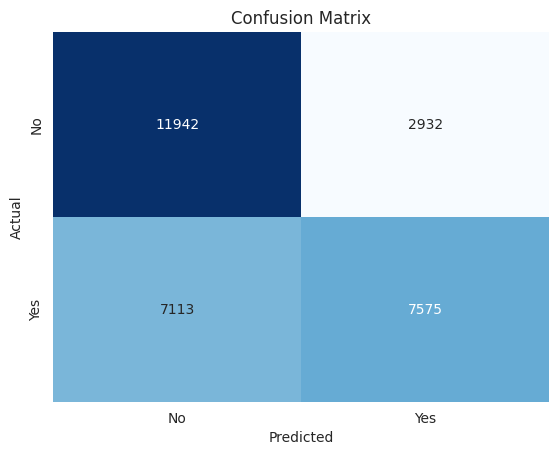

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true target variable 'y_test' and the predicted target variable 'y_pred'

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# Show the plot
plt.show()

In [207]:
feature_importances = rf_classifier.feature_importances_

# Create a dictionary with feature names as keys and importances as values
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Sort the feature importance dictionary by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

upf: 0.21989918172116563
artrite: 0.11786792109338723
hipertensão: 0.09825568218838666
hipercolesterolemia: 0.09372836725628518
cardiovascular: 0.07869841077954332
diabetes: 0.07242883742722309
obesidade: 0.06854750306009585
exerc_fisico: 0.05832583946858022
cons_alcool: 0.056749213850551004
tabagismo: 0.0554115055094093
cancer: 0.044546592135118177
avc: 0.035540945510254274


### Modelo só com variáveis sociodemográficas

In [208]:
df_total = pd.DataFrame()
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)

df_total['escolaridade'] = df['escolaridade_agregada']
df_total['class_idade'] = df['class_idade']
df_total['cor'] = df['cor']

In [209]:
df_total = df_total.dropna()

In [210]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df_total.drop('depression', axis=1)
y = df_total['depression']

In [211]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [213]:
rf_classifier = RandomForestClassifier(n_jobs=-1)

In [214]:
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8935021299574009
Precision: 0.0
Recall: 0.0
F1-score: 0.0


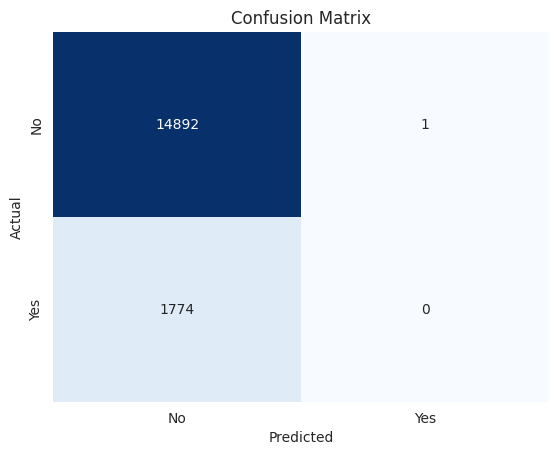

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true target variable 'y_test' and the predicted target variable 'y_pred'

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# Show the plot
plt.show()

In [216]:
feature_importances = rf_classifier.feature_importances_

# Create a dictionary with feature names as keys and importances as values
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Sort the feature importance dictionary by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

sexo: 0.5142891662670797
cor: 0.13114998608635514
escolaridade: 0.12405366913830028
estado_civil: 0.1195475249486083
class_idade: 0.1109596535596567


### Modelo com todas as variáveis de interesse

In [239]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensão'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)


df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']
df_total['cor'] = df['cor']
df_total['activity_class'] = df['activity_class']

# df_total['perc_saude'] = df['N00101'] # Variável não utilizada na literatura, meio duvidosa

df_total['renda_pc'] = df['renda_pc']

In [240]:
df_total = df_total.dropna()

#### Tentando preencher missing em Atividade física e Consumo de alcool

In [241]:
if df_total['activity_class'].isnull().any():
    # Get the existing non-missing values in the target column
    existing_values = df_total['activity_class'].dropna().unique()

    # Choose a random value from the existing values
    random_value = np.random.choice(existing_values)

    # Replace the missing values with the random value
    df_total['activity_class'].fillna(random_value, inplace=True)

In [242]:
from sklearn.impute import SimpleImputer
target_column = ['cons_alcool']

# Get the columns excluding the target column
columns_to_impute = [col for col in df_total.columns if col not in target_column]

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='median')

# Iterate over the columns and apply imputation
for col in columns_to_impute:
    df_total[col] = imputer.fit_transform(df_total[[col]])

In [252]:
from sklearn.linear_model import LogisticRegression

target_column = 'cons_alcool'

X_train = df_total.loc[~df_total[target_column].isna()].drop(columns=[target_column], axis=1)
y_train = df_total.loc[~df_total[target_column].isna(), target_column]

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model on the available df_total
model.fit(X_train, y_train)

# Obtain the indices of rows with NaN values in the binary column
missing_indices = df_total[df_total[target_column].isna()].index

# Select the features for the missing rows
X_missing = df_total.loc[missing_indices].drop(columns=[target_column], axis=1)

# Predict the missing values using the trained model
y_missing = model.predict(X_missing)

# Fill the missing values in the binary column with the predicted values
df_total.loc[missing_indices, target_column] = y_missing

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by LogisticRegression.

In [253]:
X_train

,exerc_fisico,tabagismo,cancer,hipertensão,diabetes,cardiovascular,hipercolesterolemia,avc,artrite,obesidade,depression,sexo,estado_civil,escolaridade,upf,class_idade,cor,activity_class,perc_saude,renda_pc
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,1.0,6.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,1.0,0.0,2.0,4.0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,6.0,4.0,1.0,0.0,1.0,5.0
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,1.0,4.0,0.0,1.0,4.0
15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,4.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90839,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,1.0,2.0,4.0,0.0,2.0,7.0
90840,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,5.0,2.0,2.0,0.0,2.0,3.0
90842,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0,2.0,4.0
90843,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,4.0,1.0,0.0,2.0,7.0


In [243]:
df_total['cons_alcool'].value_counts()

cons_alcool
1.0    10578
0.0     9960
Name: count, dtype: int64

In [244]:
df_total['activity_class'].value_counts()

activity_class
0.0    16497
1.0     4041
Name: count, dtype: int64

#### Voltando ao modelo

In [245]:
new_df = df.copy() # Se for analisar o banco completo, utilize o new_df e retire as perguntas já utilizadas nas variáveis criadas por nós
drop = ['N010', 'N011', 'N012', 'N013', 'N014', 'N015', 'N016', 'N017', 'N018', 'P02801', 'P050', 'depression_severity', 'phq9_total']
new_df = new_df.drop(columns=drop)

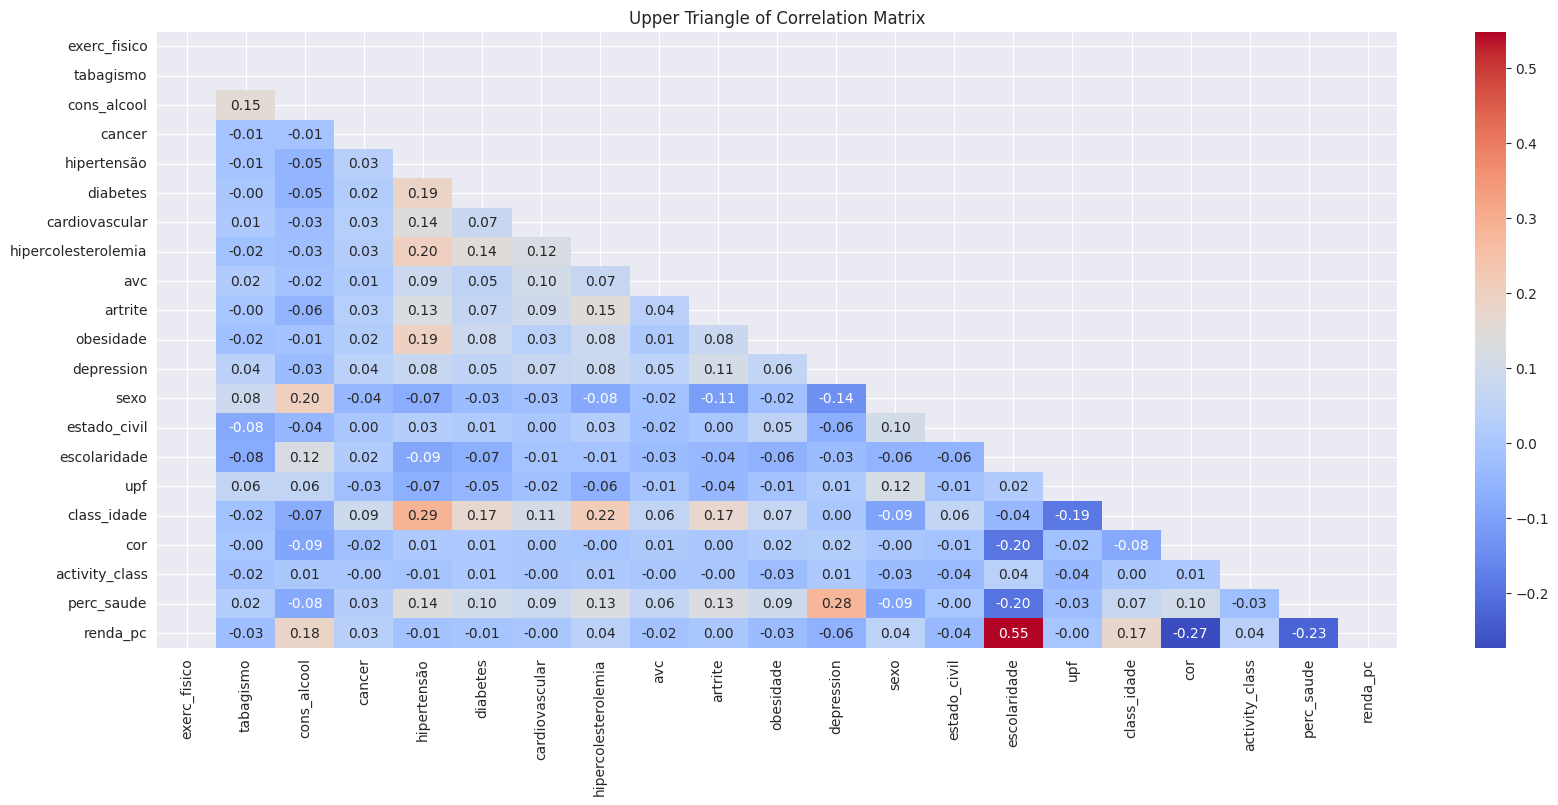

In [246]:
import numpy as np

corr_matrix = df_total.corr()
correlations = corr_matrix['depression'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
plt.show()

In [247]:
correlations.head(30)

depression             1.000000
perc_saude             0.280229
sexo                   0.141022
artrite                0.106457
hipercolesterolemia    0.080550
hipertensão            0.075149
cardiovascular         0.071597
estado_civil           0.064675
renda_pc               0.062355
obesidade              0.060733
diabetes               0.051144
avc                    0.047319
cancer                 0.043945
tabagismo              0.043571
escolaridade           0.034622
cons_alcool            0.034559
cor                    0.023829
upf                    0.013973
activity_class         0.006170
class_idade            0.002795
exerc_fisico                NaN
Name: depression, dtype: float64

In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X = df_total.drop('depression', axis=1)
y = df_total['depression']

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = smote.fit_resample(X_test, y_test)

In [250]:
from collections import Counter
Counter(y_train)

Counter({0.0: 13113, 1.0: 1263})

In [232]:
from collections import Counter
Counter(y_train)

Counter({0.0: 13113, 1.0: 1263})

### RandomForestClassifier

In [234]:
rf_classifier = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8899707887049659
Precision: 0.06417112299465241
Recall: 0.02330097087378641
F1-score: 0.03418803418803419


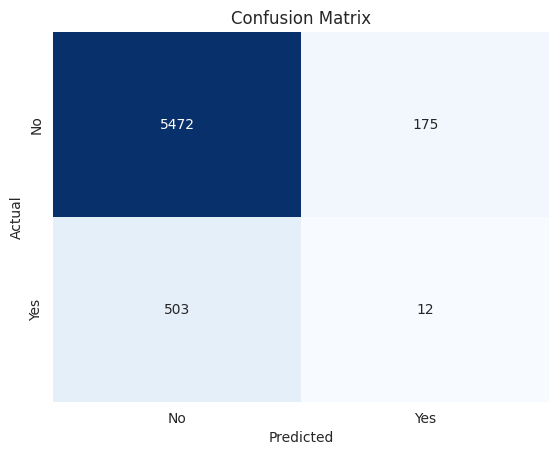

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the true target variable 'y_test' and the predicted target variable 'y_pred'

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

# Show the plot
plt.show()

In [236]:
feature_importances = rf_classifier.feature_importances_

# Create a dictionary with feature names as keys and importances as values
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}

# Sort the feature importance dictionary by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

upf: 0.18782922997740573
renda_pc: 0.15194395451706635
class_idade: 0.10878741060017068
escolaridade: 0.0970628142227799
cor: 0.08096002939109403
sexo: 0.06947197431305764
cons_alcool: 0.04936932642625747
activity_class: 0.03996570275749583
estado_civil: 0.03764148193298429
obesidade: 0.03315160912389592
hipertensão: 0.03058905629063177
hipercolesterolemia: 0.025712964001518256
tabagismo: 0.021589272298198597
artrite: 0.019093239004444578
diabetes: 0.016625716017925948
cardiovascular: 0.014262603201037989
cancer: 0.010044348832909363
avc: 0.005899267091125691
exerc_fisico: 0.0


### LogisticRegression

/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_mode

Best Hyperparameters: {'C': 1.0, 'max_iter': 100, 'solver': 'saga'}
Accuracy: 0.7252515417072379
Precision: 0.1890179514255544
Recall: 0.6951456310679611
F1-score: 0.29721876297218763


/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


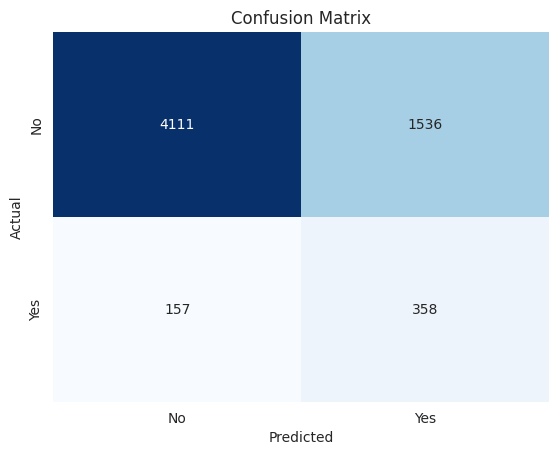

In [251]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = LogisticRegression(class_weight='balanced')

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

scoring = make_scorer(f1_score)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = LogisticRegression(class_weight='balanced')

param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

scoring = make_scorer(f1_score)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])
plt.show()

In [ ]:
feature_names = X.columns

# Create a dataframe to store the feature importance
importance_table = pd.DataFrame({'Feature': feature_names, 'Importance': best_model.coef_[0]})

# Sort the table by importance in descending order
importance_table = importance_table.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print(importance_table)

### Rede Neural

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
valid_X_tensor = torch.tensor(valid_X.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y.values, dtype=torch.float32)

dataset_train = TensorDataset(train_X_tensor, train_y_tensor)
dataset_valid = TensorDataset(valid_X_tensor, valid_y_tensor)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

input_dim = train_X_tensor.shape[1]

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the neural network model
input_dim = train_X_tensor.shape[1]
model = NeuralNetwork(input_dim)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(train_X_tensor)
    train_loss = loss_fn(train_outputs, train_y_tensor.long())

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Store training loss history
    train_loss_history.append(train_loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(valid_X_tensor)
        val_loss = loss_fn(val_outputs, valid_y_tensor.long())

    # Store validation loss history
    val_loss_history.append(val_loss.item())

    # Print the loss for every epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Filter out None and NaN values from train_loss_history and train_accuracy_history
filtered_train_loss_history = [loss for loss in train_loss_history if loss is not None and not np.isnan(loss)]
filtered_valid_loss_history = [loss for loss in val_loss_history if loss is not None and not np.isnan(loss)]

# Generate the epochs for the x-axis
epochs = range(1, len(filtered_train_loss_history) + 1)

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Valid Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
test_X_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Evaluation on test data
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_predictions = test_predictions.detach().cpu().numpy()

# Convert tensor to numpy arrays
test_y_numpy = test_y_tensor.detach().cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(test_y_numpy, test_predictions)

# Calculate F1 score
f1 = f1_score(test_y_numpy, test_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_y_numpy, test_predictions)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(cm)